In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

In [21]:
n_clusters = 5
n_samples = n_clusters * 200
viridis_colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))

def generate_data(n_clusters=n_clusters,
                  n_samples=n_clusters*200,
                  dataset='type_1',
                  std=1.5,
                  seed=2023):
    if dataset=='type_1':
        X, y = make_blobs(
            n_samples=n_samples,
            centers=n_clusters, cluster_std=std, random_state=seed
        )
    elif dataset=='type_2':
        X, y = make_blobs(
            n_samples=n_samples,
            centers=((-5, 5), (5, 5), (0, 0), (-5, -5), (5, -5)),
            cluster_std=1.5, random_state=2023
        )
    else:
        print("WRONG DATASET")
        return
    return X, y

def split_data(X, y, train_ratio=0.6):
    N = X.shape[0]
    idx = int(N*train_ratio)
    return X[:idx], X[idx:], y[:idx], y[idx:]

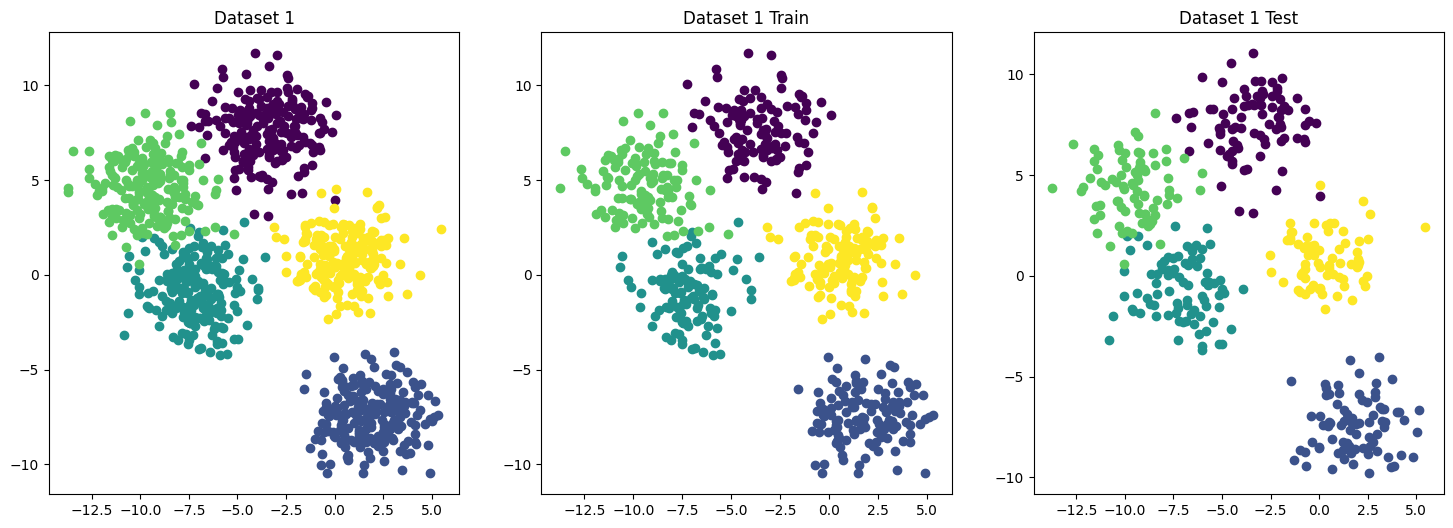

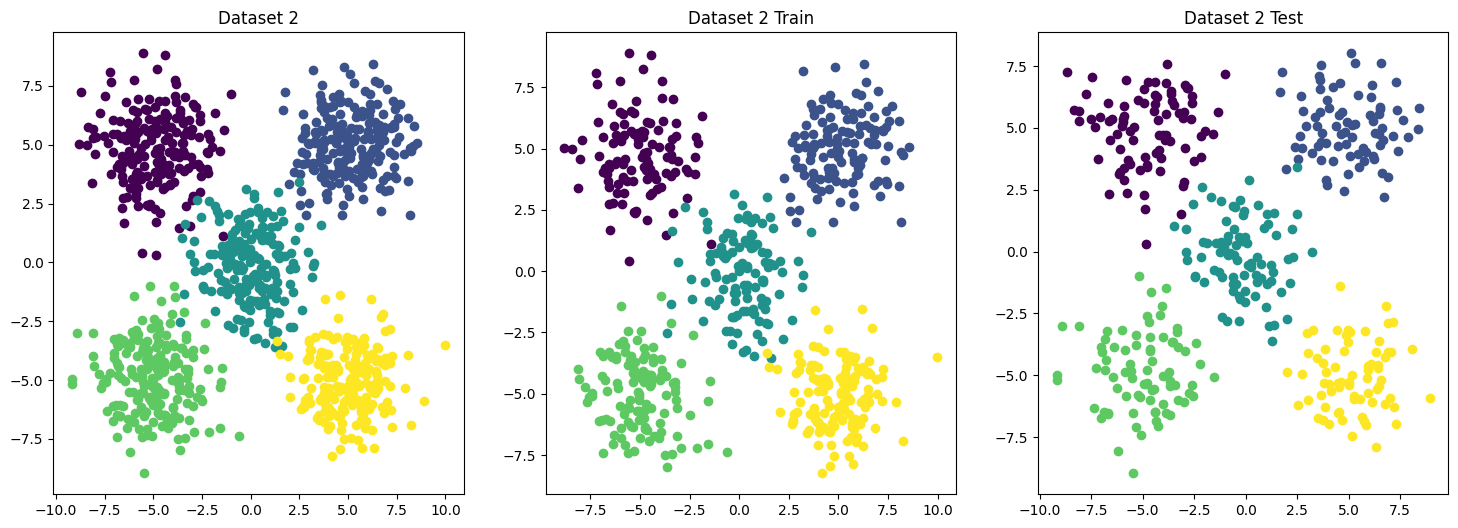

In [26]:
datasets = ['type_1', 'type_2']
for dataset in datasets:
    X, y = generate_data(dataset=dataset)
    X_train, X_test, y_train, y_test = split_data(X, y, 0.6)
    plt.figure(figsize=(18,6))
    plt.subplot(1,3,1)
    for i in range(n_clusters):
        plt.scatter(X[y == i, 0], X[y == i, 1], color=viridis_colors[i],)
    plt.title(f'Dataset {dataset.split("_")[-1]}')
    plt.subplot(1,3,2)
    for i in range(n_clusters):
        plt.scatter(X_train[y_train == i, 0], X_train[y_train == i, 1], color=viridis_colors[i],)
    plt.title(f'Dataset {dataset.split("_")[-1]} Train')
    plt.subplot(1,3,3)
    for i in range(n_clusters):
        plt.scatter(X_test[y_test == i, 0], X_test[y_test == i, 1], color=viridis_colors[i],)
    plt.title(f'Dataset {dataset.split("_")[-1]} Test')
    plt.show()

In [23]:
def one_hot(y, n_class=5):
    identity = np.eye(n_class)
    one_hot_y = identity[y]
    return one_hot_y

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / exp_z.sum(axis=1, keepdims=True)

def NLL(y, S):
    N = S.shape[0]
    return -np.sum(y*np.log(S))/N

def accuracy(y_pred, y_true):
    assert y_pred.shape[0]==y_true.shape[0], 'y_pred and y_true should have same number of element!'
    N = y_pred.shape[0]
    y_pred = np.argmax(y_pred, axis=1)
    return np.count_nonzero(y_pred==y_true)/N

In [28]:
class Classifier(object):
    def __init__(self, n_class=5):
        self.n_class = n_class
        self.W  = np.random.randn(2, n_class)
        self.B  = np.random.randn(n_class,)
        
    def fit(self, X, y, iter=100, threshold=0.1, verbose=False):
        for i in range(iter):
            loss = self.train(X, y)
            if verbose and i%10 == 0:
                print(f'{i:03}/{iter} NLL:{loss:.4f}')
            if loss < threshold:
                print(f'{i:03}/{iter} Loss < {threshold}! exit...')
                break
    def train(self, X, y):
        y_      = one_hot(y)
        N       = X.shape[0]
        A       = X.dot(self.W) + self.B
        S       = softmax(A)
        loss    = NLL(y_, S)
        self.W -= X.transpose(1,0).dot((S-y_))/N
        self.B -= np.sum(S-y_, axis=0)/N
        return loss
    
    def predict(self, X, prob=False):
        A    = X.dot(self.W) + self.B
        S    = softmax(A)
        if prob:
            return S
        else:
            return np.argmax(S, axis=1)
    
    def infer(self, X, y):
        y_   = one_hot(y)
        pred = self.predict(X, prob=True)
        loss = NLL(y_, pred)
        acc  = accuracy(pred, y)
        print(f'Test Loss: {loss:.4f} | Test Acc:{acc*100:.2f}')
        return 
    
    def plot_decision_boundary(self, X, y):
        grid_size = 500
        A, B = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), grid_size),
                        np.linspace(X[:, 1].min(), X[:, 1].max(), grid_size))
        C = self.predict(np.hstack([A.reshape(-1, 1), B.reshape(-1, 1)])).reshape(grid_size, grid_size)
        plt.contourf(A, B, C, alpha=0.3, cmap=plt.cm.viridis)
        for i in range(n_clusters):
            plt.scatter(X[y == i, 0], X[y == i, 1], color=viridis_colors[i],)
        plt.title('Decision Boundary')
        plt.show()

000/100 NLL:6.0308
010/100 NLL:2.4225
020/100 NLL:0.3891
030/100 NLL:0.2524
040/100 NLL:0.1897
050/100 NLL:0.1477
060/100 NLL:0.1186
070/100 NLL:0.0983
080/100 NLL:0.0846
090/100 NLL:0.0754
Test Loss: 0.1068 | Test Acc:96.00


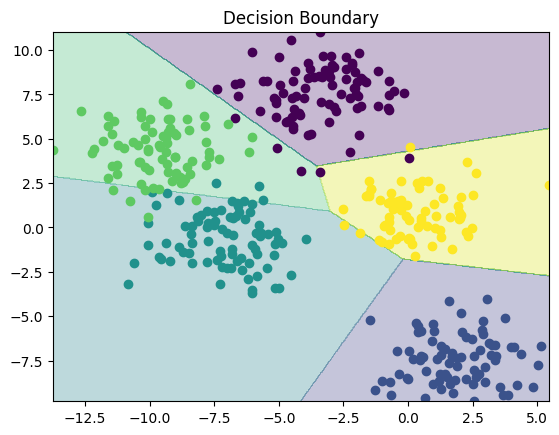

000/100 NLL:9.3190
010/100 NLL:0.2005
020/100 NLL:0.1361
030/100 NLL:0.1112
040/100 NLL:0.0965
050/100 NLL:0.0868
060/100 NLL:0.0799
070/100 NLL:0.0747
080/100 NLL:0.0707
090/100 NLL:0.0674
Test Loss: 0.0634 | Test Acc:99.00


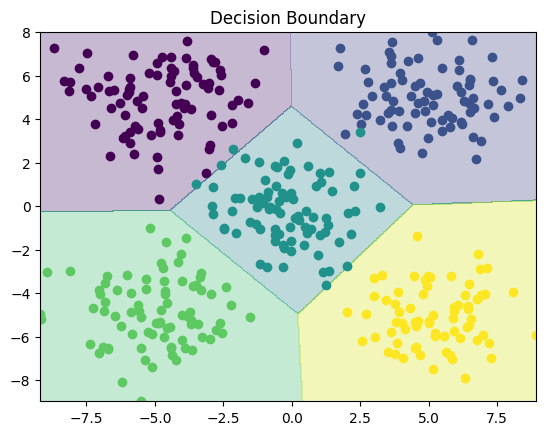

In [29]:
datasets = ['type_1', 'type_2']
for dataset in datasets:
    X, y = generate_data(dataset=dataset)
    X_train, X_test, y_train, y_test = split_data(X, y, 0.6)
    clf = Classifier()
    clf.fit(X_train, y_train, threshold=0.001, verbose=True)
    clf.infer(X_test, y_test)
    clf.plot_decision_boundary(X_test, y_test)